In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


In [2]:
df = pd.read_csv('./Data.csv', sep=';')
df.head()

,<TICKER>,<PER>,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,SBER,D,20070720,0,109.00,111.11,108.01,109.20,20241338
1,SBER,D,20070723,0,109.89,112.65,108.10,112.00,35035782
2,SBER,D,20070724,0,112.10,113.05,109.47,109.53,31682649
3,SBER,D,20070725,0,108.50,109.98,107.10,109.63,39670347
4,SBER,D,20070726,0,110.00,110.42,103.30,104.18,49852134


In [3]:
from datetime import datetime

df['<DATE>'] = pd.to_datetime(format='%Y%m%d', arg=df['<DATE>']) 

In [4]:
df = df.set_index('<DATE>')

In [5]:
df = df.asfreq(freq='1m', method='bfill')

<AxesSubplot:xlabel='<DATE>'>

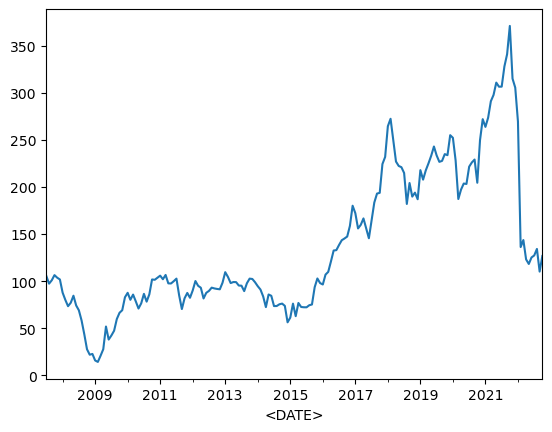

In [6]:
df['<CLOSE>'].plot()

### Автокореляционная функция

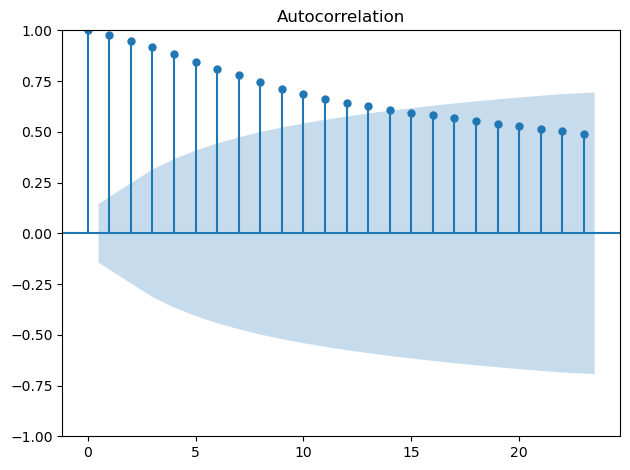

In [7]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(df['<CLOSE>'])
plt.tight_layout()

### Для аддитивной модели

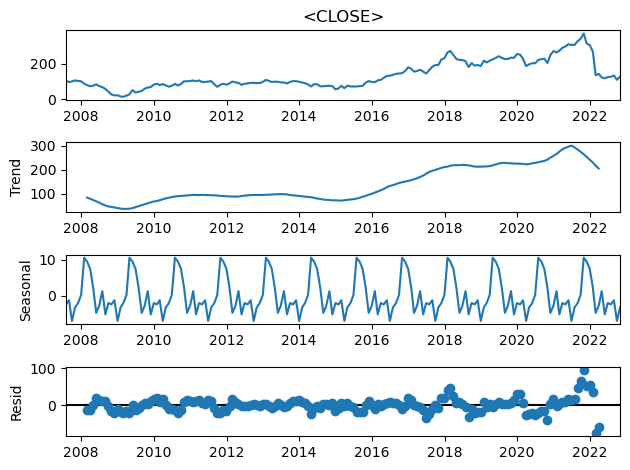

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df['<CLOSE>'], model='additive', period=15)
decomposition.plot()
plt.tight_layout()

### Проверка на сезонность, используя Mann-Kendall Test

In [13]:
import pymannkendall as mk

mk.seasonal_test(df['<CLOSE>'], period=15)

Seasonal_Mann_Kendall_Test(trend='increasing', h=True, p=0.0, z=11.073184146714151, Tau=0.6242774566473989, s=648.0, var_s=3413.9999999999995, slope=17.988611111111112, intercept=-7.180527777777783)

#### Проверка на существование тренда при помощи Hamed and Rao Modified MK Test

In [14]:
mk.hamed_rao_modification_test(df['<CLOSE>'])

Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='increasing', h=True, p=2.29353422698253e-05, z=4.23421305982817, Tau=0.5917676407697791, s=9963.0, var_s=5535382.802274252, slope=1.168512295081967, intercept=-4.3688749999999885)

### Устраним сезонную компоненту из временного ряда

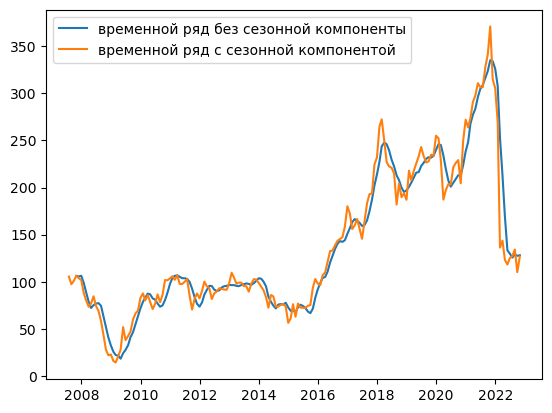

In [15]:
data_without_seasonality = (df['<CLOSE>'] - decomposition.seasonal).rolling(window=4).mean()

plt.plot(data_without_seasonality, label = 'временной ряд без сезонной компоненты')
plt.plot(df['<CLOSE>'], label = 'временной ряд с сезонной компонентой')
plt.legend()

### Полученный ряд с устраненной сезонностью

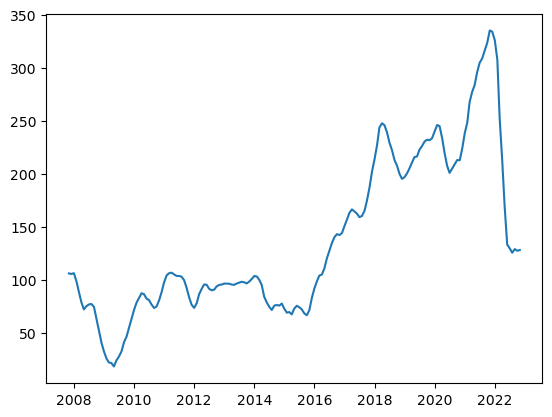

In [16]:
plt.plot(data_without_seasonality)

In [17]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

data = sm.add_constant(pd.DataFrame(data={
    'x':data_without_seasonality.reset_index()[0].dropna().index.to_numpy(),
    'values' : data_without_seasonality.reset_index()[0].dropna().values
}))

data.head()

,const,x,values
0,1.0,3,106.141001
1,1.0,4,105.607289
2,1.0,5,106.350425
3,1.0,6,98.641259
4,1.0,7,88.857459


### Прямолинейный тренд

In [18]:
model = smf.ols(formula='values ~ x', data = data)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 values   R-squared:                       0.674
Model:                            OLS   Adj. R-squared:                  0.672
Method:                 Least Squares   F-statistic:                     369.5
Date:                Sun, 27 Nov 2022   Prob (F-statistic):           2.14e-45
Time:                        15:59:15   Log-Likelihood:                -939.59
No. Observations:                 181   AIC:                             1883.
Df Residuals:                     179   BIC:                             1890.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     25.9575      6.634      3.913      0.000      12.866      39.049
x              1.1955      0.062     19.223      0.000       1.073       1.318
==============================================================================
Omnibus:                        3.242   Durbin-Watson:                   0.045
Prob(Omnibus):                  0.198   Jarque-Bera (JB):                2.839
Skew:                          -0.234   Prob(JB):                        0.242
Kurtosis:                       3.396   Cond. No.                         218.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Параболический тренд

In [71]:
model = smf.ols(formula='values ~ np.power(x, 2)', data = data)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 values   R-squared:                       0.698
Model:                            OLS   Adj. R-squared:                  0.696
Method:                 Least Squares   F-statistic:                     413.8
Date:                Sun, 27 Nov 2022   Prob (F-statistic):           2.02e-48
Time:                        16:31:13   Log-Likelihood:                -932.84
No. Observations:                 181   AIC:                             1870.
Df Residuals:                     179   BIC:                             1876.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         63.8063      4.737     13.471      0.000      54.459      73.153
np.power(x, 2)     0.0064      0.000     20.342      0.000       0.006       0.007
==============================================================================
Omnibus:                       47.725   Durbin-Watson:                   0.051
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              113.888
Skew:                          -1.146   Prob(JB):                     1.86e-25
Kurtosis:                       6.139   Cond. No.                     2.29e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.29e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

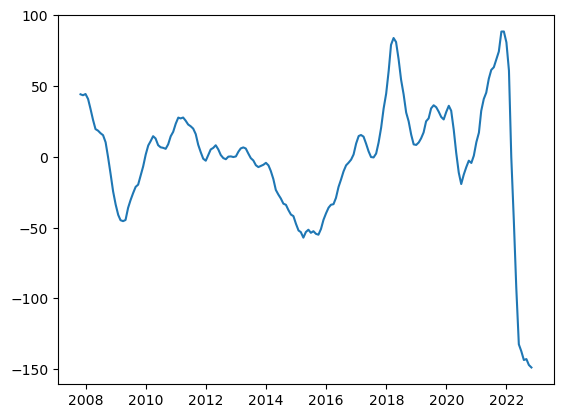

In [68]:
trend = res.fittedvalues.copy()
trend.index = data_without_seasonality.dropna().index

best_trend_model = res
best_pure_data = data_without_seasonality - trend

plt.plot(data_without_seasonality - trend)

### Гиперболический тренд

In [23]:
model = smf.ols(formula='values ~ np.divide(1, x)', data = data)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 values   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.094
Method:                 Least Squares   F-statistic:                     19.69
Date:                Sun, 27 Nov 2022   Prob (F-statistic):           1.59e-05
Time:                        16:00:39   Log-Likelihood:                -1031.5
No. Observations:                 181   AIC:                             2067.
Df Residuals:                     179   BIC:                             2073.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         151.3777      6.281     24.103      0.000     138.984     163.771
np.divide(1, x)  -600.7719    135.392     -4.437      0.000    -867.942    -333.602
==============================================================================
Omnibus:                       17.521   Durbin-Watson:                   0.022
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               19.499
Skew:                           0.774   Prob(JB):                     5.83e-05
Kurtosis:                       2.562   Cond. No.                         25.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Логарифмический тренд

In [25]:
model = smf.ols(formula='values ~ np.log(x)', data = data)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 values   R-squared:                       0.437
Model:                            OLS   Adj. R-squared:                  0.433
Method:                 Least Squares   F-statistic:                     138.7
Date:                Sun, 27 Nov 2022   Prob (F-statistic):           4.44e-24
Time:                        16:00:43   Log-Likelihood:                -989.01
No. Observations:                 181   AIC:                             1982.
Df Residuals:                     179   BIC:                             1988.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -112.4152     21.613     -5.201      0.000    -155.065     -69.766
np.log(x)     58.4215      4.960     11.779      0.000      48.634      68.209
==============================================================================
Omnibus:                       13.996   Durbin-Watson:                   0.028
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               15.768
Skew:                           0.720   Prob(JB):                     0.000377
Kurtosis:                       2.879   Cond. No.                         23.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Экспоненциальный тренд

In [27]:
model = smf.ols(formula='values ~ np.exp(x)', data = data)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 values   R-squared:                      -3.213
Model:                            OLS   Adj. R-squared:                 -3.213
Method:                 Least Squares   F-statistic:                       nan
Date:                Sun, 27 Nov 2022   Prob (F-statistic):                nan
Time:                        16:00:48   Log-Likelihood:                -1171.1
No. Observations:                 181   AIC:                             2344.
Df Residuals:                     180   BIC:                             2347.
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  2.681e-157  2.23e-157      1.204      0.230  -1.71e-157   7.07e-157
np.exp(x)   5.863e-78   4.87e-78      1.204      0.230   -3.75e-78    1.55e-77
==============================================================================
Omnibus:                       14.541   Durbin-Watson:                   0.007
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               16.180
Skew:                           0.712   Prob(JB):                     0.000307
Kurtosis:                       2.661   Cond. No.                     2.41e+78
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.41e+78. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Логистический тренд

In [29]:
model = smf.ols(formula='values ~ np.divide(1, 1 + np.exp(-x))', data = data)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 values   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.3848
Date:                Sun, 27 Nov 2022   Prob (F-statistic):              0.536
Time:                        16:00:52   Log-Likelihood:                -1040.7
No. Observations:                 181   AIC:                             2085.
Df Residuals:                     179   BIC:                             2092.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                     -793.7754   1500.740     -0.529      0.598   -3755.193    2167.642
np.divide(1, 1 + np.exp(-x))   931.3068   1501.359      0.620      0.536   -2031.334    3893.948
==============================================================================
Omnibus:                       16.663   Durbin-Watson:                   0.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               18.733
Skew:                           0.764   Prob(JB):                     8.55e-05
Kurtosis:                       2.610   Cond. No.                         528.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Для Аддитивной модели

In [76]:
mk.seasonal_test(best_pure_data['values'])

Seasonal_Mann_Kendall_Test(trend='no trend', h=False, p=0.12610416841752592, z=1.529646841063363, Tau=0.08549019607843138, s=109.0, var_s=4985.0, slope=1.0911469682608488, intercept=-3.5885335119517663)

In [75]:
mk.hamed_rao_modification_test(best_pure_data['values'])

Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='no trend', h=False, p=0.46365533589174923, z=0.7328411239731478, Tau=0.0843462246777164, s=1374.0, var_s=3510115.5250202813, slope=0.09082287463649934, intercept=-3.5789899672803394)

In [47]:
best_pure_data.name = 'values'
best_pure_data = best_pure_data.reset_index()
best_pure_data['x'] = best_pure_data.index

In [48]:
best_pure_data = best_pure_data.dropna()
best_pure_data

,<DATE>,values,x
3,2007-10-31,37.752626,3
4,2007-11-30,37.279210,4
5,2007-12-31,38.345436,5
6,2008-01-31,34.985351,6
7,2008-02-29,28.306282,7
...,...,...,...
179,2022-06-30,-140.847991,179
180,2022-07-31,-147.207784,180
181,2022-08-31,-146.724795,181
182,2022-09-30,-151.043106,182


In [49]:
model = smf.ols(formula='values ~ x + np.power(x, 2) + np.power(x, 3) + np.power(x, 4)', data=best_pure_data)
res = model.fit()

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 values   R-squared:                       0.359
Model:                            OLS   Adj. R-squared:                  0.345
Method:                 Least Squares   F-statistic:                     24.69
Date:                Sun, 27 Nov 2022   Prob (F-statistic):           3.11e-16
Time:                        16:03:10   Log-Likelihood:                -892.53
No. Observations:                 181   AIC:                             1795.
Df Residuals:                     176   BIC:                             1811.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        -31.5640     14.894     -2.119      0.035     -60.958      -2.170
x                  4.3494      1.076      4.041      0.000       2.225       6.474
np.power(x, 2)    -0.1292      0.023     -5.596      0.000      -0.175      -0.084
np.power(x, 3)     0.0013      0.000      6.749      0.000       0.001       0.002
np.power(x, 4) -3.748e-06   4.95e-07     -7.578      0.000   -4.72e-06   -2.77e-06
==============================================================================
Omnibus:                        9.359   Durbin-Watson:                   0.072
Prob(Omnibus):                  0.009   Jarque-Bera (JB):               10.378
Skew:                           0.421   Prob(JB):                      0.00558
Kurtosis:                       3.816   Cond. No.                     2.25e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.25e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

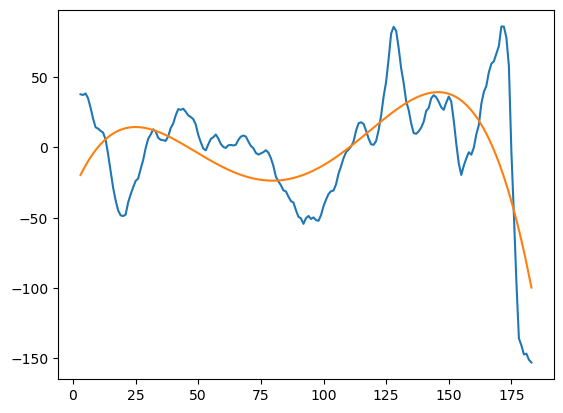

In [50]:
plt.plot(best_pure_data['values'])
plt.plot(res.fittedvalues)

In [51]:
fitted_vals = res.fittedvalues
fitted_vals.index = best_pure_data['<DATE>']

trend_vals = best_trend_model.fittedvalues
trend_vals.index = best_pure_data['<DATE>']

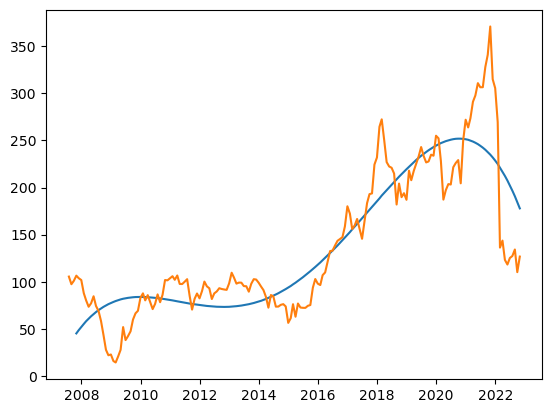

In [52]:
plt.plot(trend_vals + decomposition.seasonal + fitted_vals)
plt.plot(df['<CLOSE>'])

In [53]:
def convert_to_timestamp(i: int) -> pd.Timestamp:
    return pd.Timestamp('2007-7-31 00:00:00') + pd.DateOffset(months=i)

In [54]:
timestamps = { j:i for i,j in zip(res.fittedvalues.index, best_pure_data['<DATE>'])}

In [61]:
seasonal = decomposition.seasonal.reset_index()['seasonal']
seasonal[0:]

0      0.983615
1      0.988175
2      0.952843
3      0.960931
4      0.939336
         ...   
179    0.999211
180    0.983615
181    0.988175
182    0.952843
183    0.960931
Name: seasonal, Length: 184, dtype: float64

In [62]:
seasonal = pd.concat([seasonal[0:180] ,pd.Series(data = seasonal[:15].values, index=np.arange(180, 195))])

In [63]:
seasonal

0      0.983615
1      0.988175
2      0.952843
3      0.960931
4      0.939336
         ...   
190    1.011812
191    1.020346
192    1.046874
193    0.997184
194    0.999211
Length: 195, dtype: float64

In [64]:
dt = pd.DataFrame(data = {
    'x':[183, 184, 185, 186, 187, 188, 189, 190, 191]
})

In [65]:
dt['predicted_model'] = res.predict(dt['x'])
dt['trend_vals'] = best_trend_model.predict(dt['x'])
dt['seasonality'] = seasonal[dt['x']].values
dt['date'] = dt['x'].apply(convert_to_timestamp)
dt.index = dt['date']

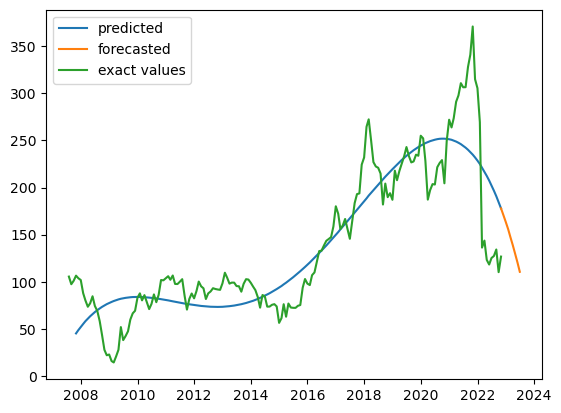

In [66]:
plt.plot(trend_vals + decomposition.seasonal + fitted_vals, label='predicted')
plt.plot(dt['trend_vals'] + dt['predicted_model'] + dt['seasonality'], label='forecasted')
plt.plot(df['<CLOSE>'], label='exact values')
plt.legend()

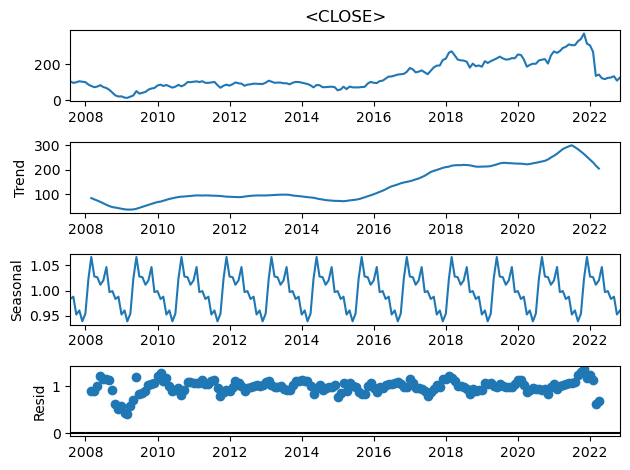

In [31]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df['<CLOSE>'], model='multiplicative', period=15)
decomposition.plot()
plt.tight_layout()

### Устраним сезонность

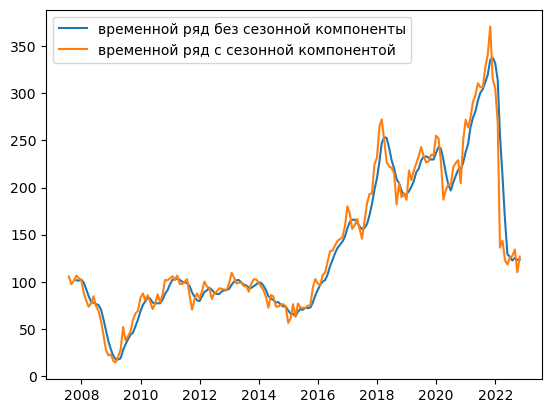

In [32]:
data_without_seasonality = (df['<CLOSE>'] - decomposition.seasonal).rolling(window=4).mean()

plt.plot(data_without_seasonality, label = 'временной ряд без сезонной компоненты')
plt.plot(df['<CLOSE>'], label = 'временной ряд с сезонной компонентой')
plt.legend()

### Полученный ряд с устраненной сезонностью

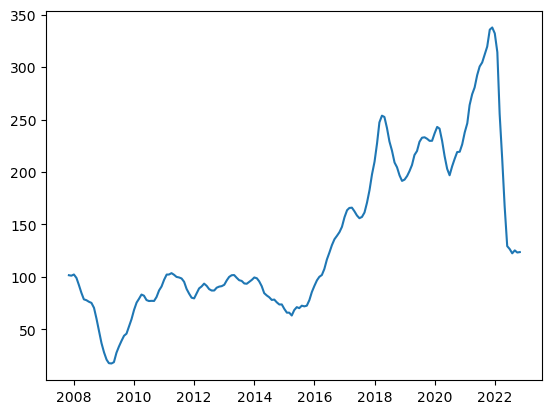

In [33]:
plt.plot(data_without_seasonality)

In [34]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

data = sm.add_constant(pd.DataFrame(data={
    'x':data_without_seasonality.reset_index()[0].dropna().index.to_numpy(),
    'values' : data_without_seasonality.reset_index()[0].dropna().values
}))

data.head()

,const,x,values
0,1.0,3,101.616109
1,1.0,4,101.187179
2,1.0,5,102.310601
3,1.0,6,99.020422
4,1.0,7,92.423969


### Прямолинейный тренд

In [35]:
model = smf.ols(formula='values ~ x', data = data)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 values   R-squared:                       0.670
Model:                            OLS   Adj. R-squared:                  0.668
Method:                 Least Squares   F-statistic:                     362.7
Date:                Sun, 27 Nov 2022   Prob (F-statistic):           6.57e-45
Time:                        16:01:22   Log-Likelihood:                -940.99
No. Observations:                 181   AIC:                             1886.
Df Residuals:                     179   BIC:                             1892.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     25.1097      6.686      3.756      0.000      11.917      38.302
x              1.1937      0.063     19.046      0.000       1.070       1.317
==============================================================================
Omnibus:                        3.774   Durbin-Watson:                   0.046
Prob(Omnibus):                  0.152   Jarque-Bera (JB):                3.504
Skew:                          -0.234   Prob(JB):                        0.173
Kurtosis:                       3.496   Cond. No.                         218.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Параболический тренд

In [37]:
model = smf.ols(formula='values ~ np.power(x, 2)', data = data)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 values   R-squared:                       0.698
Model:                            OLS   Adj. R-squared:                  0.696
Method:                 Least Squares   F-statistic:                     413.8
Date:                Sun, 27 Nov 2022   Prob (F-statistic):           2.02e-48
Time:                        16:01:30   Log-Likelihood:                -932.84
No. Observations:                 181   AIC:                             1870.
Df Residuals:                     179   BIC:                             1876.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         63.8063      4.737     13.471      0.000      54.459      73.153
np.power(x, 2)     0.0064      0.000     20.342      0.000       0.006       0.007
==============================================================================
Omnibus:                       47.725   Durbin-Watson:                   0.051
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              113.888
Skew:                          -1.146   Prob(JB):                     1.86e-25
Kurtosis:                       6.139   Cond. No.                     2.29e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.29e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

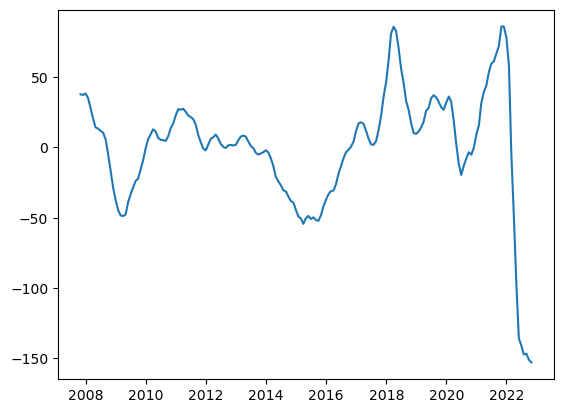

In [38]:
trend = res.fittedvalues.copy()
trend.index = data_without_seasonality.dropna().index

plt.plot(data_without_seasonality - trend)

best_trend_model = res
best_pure_data = data_without_seasonality - trend

### Гиперболический тренд

In [39]:
model = smf.ols(formula='values ~ np.divide(1, x)', data = data)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 values   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.094
Method:                 Least Squares   F-statistic:                     19.74
Date:                Sun, 27 Nov 2022   Prob (F-statistic):           1.55e-05
Time:                        16:02:02   Log-Likelihood:                -1031.7
No. Observations:                 181   AIC:                             2067.
Df Residuals:                     179   BIC:                             2074.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         150.3977      6.289     23.914      0.000     137.987     162.808
np.divide(1, x)  -602.4387    135.577     -4.444      0.000    -869.974    -334.904
==============================================================================
Omnibus:                       17.855   Durbin-Watson:                   0.022
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               20.093
Skew:                           0.788   Prob(JB):                     4.33e-05
Kurtosis:                       2.575   Cond. No.                         25.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Логарифмический тренд

In [41]:
model = smf.ols(formula='values ~ np.log(x)', data = data)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 values   R-squared:                       0.434
Model:                            OLS   Adj. R-squared:                  0.431
Method:                 Least Squares   F-statistic:                     137.3
Date:                Sun, 27 Nov 2022   Prob (F-statistic):           6.61e-24
Time:                        16:02:09   Log-Likelihood:                -989.68
No. Observations:                 181   AIC:                             1983.
Df Residuals:                     179   BIC:                             1990.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -113.0961     21.693     -5.213      0.000    -155.904     -70.288
np.log(x)     58.3422      4.978     11.719      0.000      48.518      68.166
==============================================================================
Omnibus:                       14.342   Durbin-Watson:                   0.029
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               16.243
Skew:                           0.730   Prob(JB):                     0.000297
Kurtosis:                       2.856   Cond. No.                         23.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Экспоненциальный тренд

In [43]:
model = smf.ols(formula='values ~ np.exp(x)', data = data)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 values   R-squared:                      -3.158
Model:                            OLS   Adj. R-squared:                 -3.158
Method:                 Least Squares   F-statistic:                       nan
Date:                Sun, 27 Nov 2022   Prob (F-statistic):                nan
Time:                        16:02:14   Log-Likelihood:                -1170.2
No. Observations:                 181   AIC:                             2342.
Df Residuals:                     180   BIC:                             2346.
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  2.591e-157  2.22e-157      1.169      0.244  -1.78e-157   6.96e-157
np.exp(x)   5.665e-78   4.84e-78      1.169      0.244   -3.89e-78    1.52e-77
==============================================================================
Omnibus:                       15.051   Durbin-Watson:                   0.007
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               16.940
Skew:                           0.732   Prob(JB):                     0.000210
Kurtosis:                       2.680   Cond. No.                     2.41e+78
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.41e+78. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Логистический тренд

In [45]:
model = smf.ols(formula='values ~ np.divide(1, 1 + np.exp(-x))', data = data)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 values   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.4627
Date:                Sun, 27 Nov 2022   Prob (F-statistic):              0.497
Time:                        16:02:53   Log-Likelihood:                -1041.0
No. Observations:                 181   AIC:                             2086.
Df Residuals:                     179   BIC:                             2092.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                     -886.0062   1502.671     -0.590      0.556   -3851.236    2079.224
np.divide(1, 1 + np.exp(-x))  1022.5565   1503.292      0.680      0.497   -1943.898    3989.011
==============================================================================
Omnibus:                       17.035   Durbin-Watson:                   0.016
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               19.435
Skew:                           0.782   Prob(JB):                     6.02e-05
Kurtosis:                       2.638   Cond. No.                         528.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [76]:
mk.seasonal_test(best_pure_data['values'])

Seasonal_Mann_Kendall_Test(trend='no trend', h=False, p=0.12610416841752592, z=1.529646841063363, Tau=0.08549019607843138, s=109.0, var_s=4985.0, slope=1.0911469682608488, intercept=-3.5885335119517663)

In [75]:
mk.hamed_rao_modification_test(best_pure_data['values'])

Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='no trend', h=False, p=0.46365533589174923, z=0.7328411239731478, Tau=0.0843462246777164, s=1374.0, var_s=3510115.5250202813, slope=0.09082287463649934, intercept=-3.5789899672803394)

In [47]:
best_pure_data.name = 'values'
best_pure_data = best_pure_data.reset_index()
best_pure_data['x'] = best_pure_data.index

In [48]:
best_pure_data = best_pure_data.dropna()
best_pure_data

,<DATE>,values,x
3,2007-10-31,37.752626,3
4,2007-11-30,37.279210,4
5,2007-12-31,38.345436,5
6,2008-01-31,34.985351,6
7,2008-02-29,28.306282,7
...,...,...,...
179,2022-06-30,-140.847991,179
180,2022-07-31,-147.207784,180
181,2022-08-31,-146.724795,181
182,2022-09-30,-151.043106,182


In [49]:
model = smf.ols(formula='values ~ x + np.power(x, 2) + np.power(x, 3) + np.power(x, 4)', data=best_pure_data)
res = model.fit()

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 values   R-squared:                       0.359
Model:                            OLS   Adj. R-squared:                  0.345
Method:                 Least Squares   F-statistic:                     24.69
Date:                Sun, 27 Nov 2022   Prob (F-statistic):           3.11e-16
Time:                        16:03:10   Log-Likelihood:                -892.53
No. Observations:                 181   AIC:                             1795.
Df Residuals:                     176   BIC:                             1811.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        -31.5640     14.894     -2.119      0.035     -60.958      -2.170
x                  4.3494      1.076      4.041      0.000       2.225       6.474
np.power(x, 2)    -0.1292      0.023     -5.596      0.000      -0.175      -0.084
np.power(x, 3)     0.0013      0.000      6.749      0.000       0.001       0.002
np.power(x, 4) -3.748e-06   4.95e-07     -7.578      0.000   -4.72e-06   -2.77e-06
==============================================================================
Omnibus:                        9.359   Durbin-Watson:                   0.072
Prob(Omnibus):                  0.009   Jarque-Bera (JB):               10.378
Skew:                           0.421   Prob(JB):                      0.00558
Kurtosis:                       3.816   Cond. No.                     2.25e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.25e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

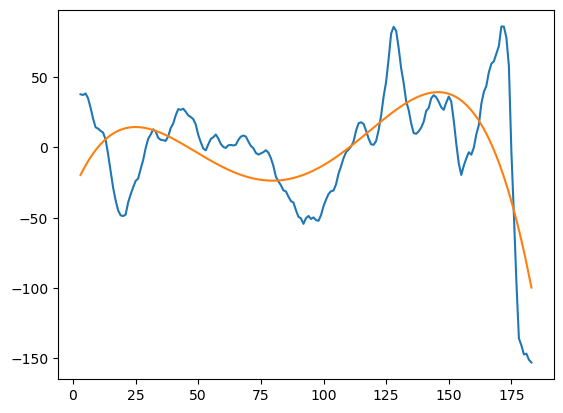

In [50]:
plt.plot(best_pure_data['values'])
plt.plot(res.fittedvalues)

In [51]:
fitted_vals = res.fittedvalues
fitted_vals.index = best_pure_data['<DATE>']

trend_vals = best_trend_model.fittedvalues
trend_vals.index = best_pure_data['<DATE>']

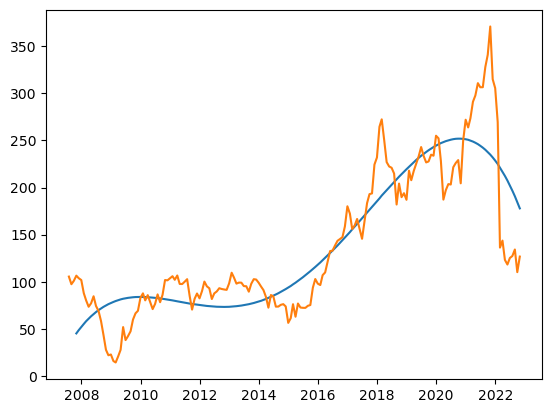

In [52]:
plt.plot(trend_vals + decomposition.seasonal + fitted_vals)
plt.plot(df['<CLOSE>'])

In [53]:
def convert_to_timestamp(i: int) -> pd.Timestamp:
    return pd.Timestamp('2007-7-31 00:00:00') + pd.DateOffset(months=i)

In [54]:
timestamps = { j:i for i,j in zip(res.fittedvalues.index, best_pure_data['<DATE>'])}

In [61]:
seasonal = decomposition.seasonal.reset_index()['seasonal']
seasonal[0:]

0      0.983615
1      0.988175
2      0.952843
3      0.960931
4      0.939336
         ...   
179    0.999211
180    0.983615
181    0.988175
182    0.952843
183    0.960931
Name: seasonal, Length: 184, dtype: float64

In [62]:
seasonal = pd.concat([seasonal[0:180] ,pd.Series(data = seasonal[:15].values, index=np.arange(180, 195))])

In [63]:
seasonal

0      0.983615
1      0.988175
2      0.952843
3      0.960931
4      0.939336
         ...   
190    1.011812
191    1.020346
192    1.046874
193    0.997184
194    0.999211
Length: 195, dtype: float64

In [64]:
dt = pd.DataFrame(data = {
    'x':[183, 184, 185, 186, 187, 188, 189, 190, 191]
})

In [65]:
dt['predicted_model'] = res.predict(dt['x'])
dt['trend_vals'] = best_trend_model.predict(dt['x'])
dt['seasonality'] = seasonal[dt['x']].values
dt['date'] = dt['x'].apply(convert_to_timestamp)
dt.index = dt['date']

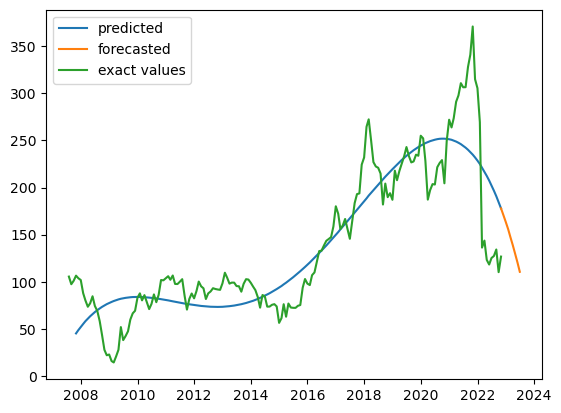

In [66]:
plt.plot(trend_vals + decomposition.seasonal + fitted_vals, label='predicted')
plt.plot(dt['trend_vals'] + dt['predicted_model'] + dt['seasonality'], label='forecasted')
plt.plot(df['<CLOSE>'], label='exact values')
plt.legend()